# Source code

In [6]:
library(dplyr)
library(ggplot2)
library(tidyselect)


Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union




In [7]:
#install.packages("gridExtra")
#install.packages("qqman")
library(gridExtra)
library(qqman)


Attaching package: ‘gridExtra’


The following object is masked from ‘package:dplyr’:

    combine




For example usage please run: vignette('qqman')



Citation appreciated but not required:

Turner, (2018). qqman: an R package for visualizing GWAS results using Q-Q and manhattan plots. Journal of Open Source Software, 3(25), 731, https://doi.org/10.21105/joss.00731.





## 1. Quality Control

## Sample QC

### Identification of individuals with elevated missing data rates or outlying heterozygosity rates

Bash commands:   
`plink --bfile eye_color --missing --allow-no-sex --out eye_color_QC`

`plink --bfile eye_color --het --allow-no-sex --out eye_color_QC`

In [4]:
#missing data
d_miss <- read.table("eye_color_QC.imiss",header=T)

#heterozygosity
d_het <- read.table("eye_color_QC.het",header=T)

#join the two tables
d <- inner_join(d_miss,d_het)

#calculate the observed heterozygosity rate per individual
d <- d %>% mutate(het_rate = (N.NM.-O.HOM.)/N.NM.)
#N.NM is the number of non-missing genotypes pr individual and O.HOM is the observed number of homozygous genotypes.

head(d)

Joining, by = c("FID", "IID")



,FID,IID,MISS_PHENO,N_MISS,N_GENO,F_MISS,O.HOM.,E.HOM.,N.NM.,F,het_rate
,<int>,<int>,<chr>,<int>,<int>,<dbl>,<int>,<dbl>,<int>,<dbl>,<dbl>
1,1010,1010,Y,417559,958847,0.435500,355012,353100,522943,0.011510,0.3211268
2,1013,1013,Y,1589,958847,0.001657,622171,618900,897402,0.011880,0.3066976
3,1020,1020,Y,3555,958847,0.003708,620700,617700,895619,0.010850,0.3069598
4,1022,1022,Y,23735,958847,0.024750,609152,605200,877300,0.014590,0.3056514
5,1024,1024,Y,23896,958847,0.024920,606768,605000,876929,0.006683,0.3080763
6,1026,1026,Y,23264,958847,0.024260,611711,605300,877569,0.023400,0.3029483


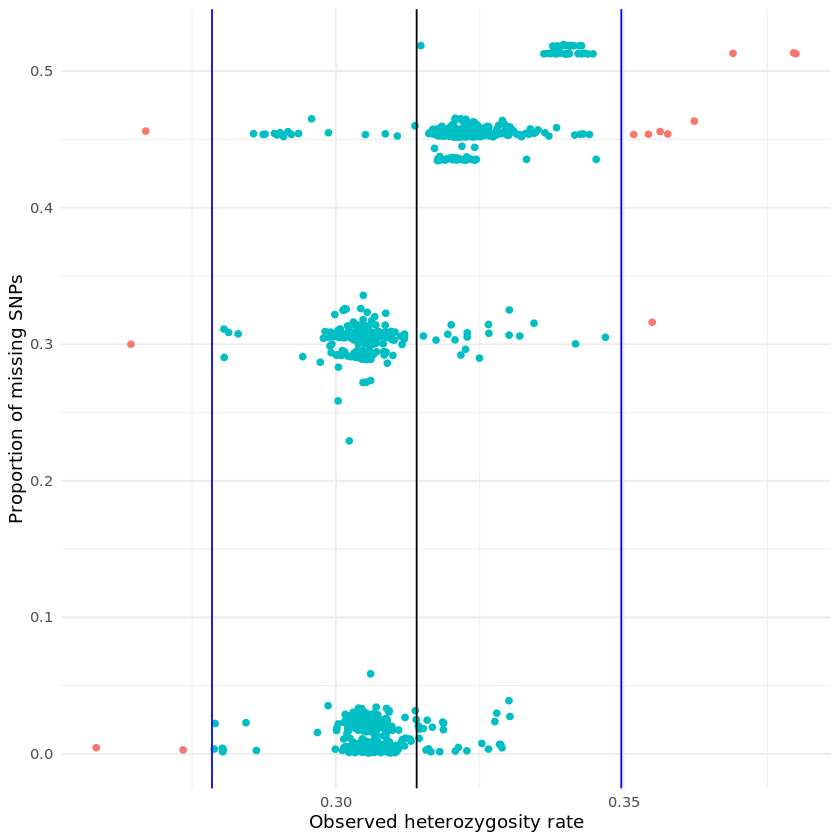

In [5]:
#plotting the observed heterozygosity rate against the proportion of missing SNPs
mean_heterozygosiy  <- mean(d$het_rate)
sd_heterozygosity  <- sd(d$het_rate)

d  %>% mutate(bounds = abs(het_rate-mean_heterozygosiy) < 3*sd_heterozygosity) %>% 
ggplot()+
geom_point(aes(x = het_rate,y = F_MISS, color = bounds)) +
geom_vline(xintercept = mean_heterozygosiy, color ="black") +
geom_vline(xintercept = mean_heterozygosiy-3*sd_heterozygosity, color ="blue") +
geom_vline(xintercept = mean_heterozygosiy+3*sd_heterozygosity, color ="blue") +  
theme_minimal() + theme(legend.position = "none") +
xlab("Observed heterozygosity rate") + ylab("Proportion of missing SNPs")

In [6]:
#write out the individuals that should be removed due to outlying heterozygosity rates
tofilter <- d %>% 
    filter(abs(het_rate-mean_heterozygosiy) > 3*sd_heterozygosity)
tofilter

tofilter %>% 
    select(FID, IID) %>% 
    write.table(file = "wrong_het_missing_values.txt", sep = "\t", row.names = FALSE, col.names = FALSE)

FID,IID,MISS_PHENO,N_MISS,N_GENO,F_MISS,O.HOM.,E.HOM.,N.NM.,F,het_rate
<int>,<int>,<chr>,<int>,<int>,<dbl>,<int>,<dbl>,<int>,<dbl>,<dbl>
2053,2053,Y,287683,958847,0.300000,481143,451900,654052,0.14450,0.2643658
2887,2887,Y,437005,958847,0.455800,318819,333900,495340,-0.09349,0.3563633
2907,2907,Y,437299,958847,0.456100,362792,333600,494902,0.18080,0.2669417
3783,3783,Y,444472,958847,0.463500,311908,329600,489119,-0.11110,0.3623065
4006,4006,Y,435150,958847,0.453800,320729,334900,496740,-0.08743,0.3543322
44,44,Y,2768,958847,0.002887,651807,618700,897111,0.11900,0.2734377
483,483,Y,4333,958847,0.004519,664180,617600,895527,0.16770,0.2583362
5867,5867,Y,303054,958847,0.316100,402855,431800,624571,-0.15020,0.3549893
5989,5989,Y,435297,958847,0.454000,319130,334900,496846,-0.09762,0.3576883


Bash commands:  
`plink --bfile eye_color --allow-no-sex --remove wrong_het_missing_values.txt "--make-bed" --out eye_color_QC`

### Identification of related individuals
Bash commands:  
`plink --bfile eye_color_QC --allow-no-sex --indep-pairwise 500kb 5 0.2 --out eye_color_QC`  
`plink --bfile eye_color_QC --allow-no-sex --extract eye_color_QC.prune.in --genome --min 0.185 --out eye_color_QC`  


In [7]:
ibd <- read.table('eye_color_QC.genome', header = TRUE)
ibd
members <- ibd$FID1 #we will remove individuals in the first column
members <- unique(members)
print("removed individuals:")
print(members)
write.table(cbind(members,members), file = 'wrong_ibd.txt', col.names = F, row.names = F)

FID1,IID1,FID2,IID2,RT,EZ,Z0,Z1,Z2,PI_HAT,PHE,DST,PPC,RATIO
<int>,<int>,<int>,<int>,<chr>,<lgl>,<dbl>,<dbl>,<dbl>,<dbl>,<int>,<dbl>,<dbl>,<dbl>
1173,1173,4814,4814,UN,NA,0.0000,0.0000,1.0000,1.0000,-1,1.000000,1,NA
1269,1269,1275,1275,UN,NA,0.0016,0.9596,0.0388,0.5186,-1,0.873349,1,1843.5000
1424,1424,6035,6035,UN,NA,0.0000,0.0000,1.0000,1.0000,-1,1.000000,1,NA
1775,1775,2083,2083,UN,NA,0.0000,0.0000,1.0000,1.0000,-1,1.000000,1,NA
2651,2651,912,912,UN,NA,0.0019,0.9757,0.0225,0.5103,-1,0.871179,1,1147.6667
3998,3998,6191,6191,UN,NA,0.0000,0.0000,1.0000,1.0000,-1,1.000000,1,NA
4460,4460,5895,5895,UN,NA,0.0000,0.0000,1.0000,1.0000,-1,1.000000,1,NA
4547,4547,4632,4632,UN,NA,0.5345,0.4655,0.0000,0.2327,-1,0.804813,1,4.2488
4583,4583,4584,4584,UN,NA,0.2415,0.5295,0.2290,0.4938,-1,0.879323,1,10.9805


[1] "removed individuals:"
 [1] 1173 1269 1424 1775 2651 3998 4460 4547 4583 4584 5792  651 8915 9277


Bash commands:  
`plink --bfile eye_color_QC --allow-no-sex --remove wrong_ibd.txt --make-bed --out eye_color_QC`

## SNP QC

### Identification of SNPs with excessive missing data rates

Bash commands:   
`plink --bfile eye_color_QC --missing --allow-no-sex --out eye_color_QC`   


,CHR,SNP,N_MISS,N_GENO,F_MISS
,<int>,<chr>,<int>,<int>,<dbl>
1,1,rs4477212,618,1260,0.49050
2,1,rs3094315,699,1260,0.55480
3,1,rs3131972,41,1260,0.03254
4,1,rs12124819,272,1260,0.21590
5,1,rs11240777,35,1260,0.02778
6,1,rs6681049,584,1260,0.46350


Warning message:
“Removed 1766 rows containing non-finite values (stat_bin).”


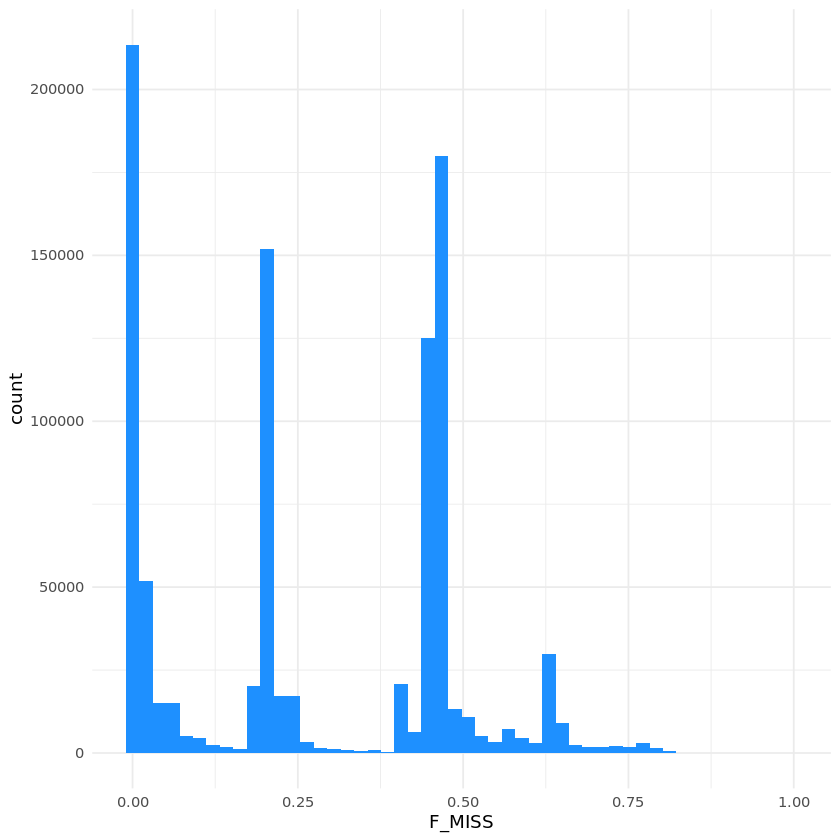

In [8]:
lmiss <- read.table("eye_color_QC.lmiss", header = T) ##CHANGE AXIS AND COLOR
head(lmiss)
lmiss %>%
    ggplot(aes(x=F_MISS)) +
    geom_histogram(bins=50,fill="dodgerblue") + theme_minimal()

Bash commands:  
`plink --bfile eye_color_QC --geno 0.75 --hwe 0.00001 --maf 0.01 --make-bed --allow-no-sex --out eye_color_QC`

## 2. Creating a binary phenotype

In [3]:
eyecolor_qc <- read.table("eye_color_QC.fam")
colnames(eyecolor_qc) <- c("FID","IID","PAT","MAT","SEX","PHENO")
head(eyecolor_qc)
phenotype <- read.table("eye_color.txt") 
colnames(phenotype) <- c("IID", "PHENO")
head(phenotype)

,FID,IID,PAT,MAT,SEX,PHENO
,<int>,<int>,<int>,<int>,<int>,<int>
1,1010,1010,0,0,0,-9
2,1013,1013,0,0,0,-9
3,1020,1020,0,0,0,-9
4,1022,1022,0,0,0,-9
5,1024,1024,0,0,0,-9
6,1026,1026,0,0,0,-9


,IID,PHENO
,<int>,<chr>
1,1010,brown
2,1013,hazel/brown-green
3,1020,blue
4,1022,blue-green
5,1024,blue
6,1026,hazel/brown-green


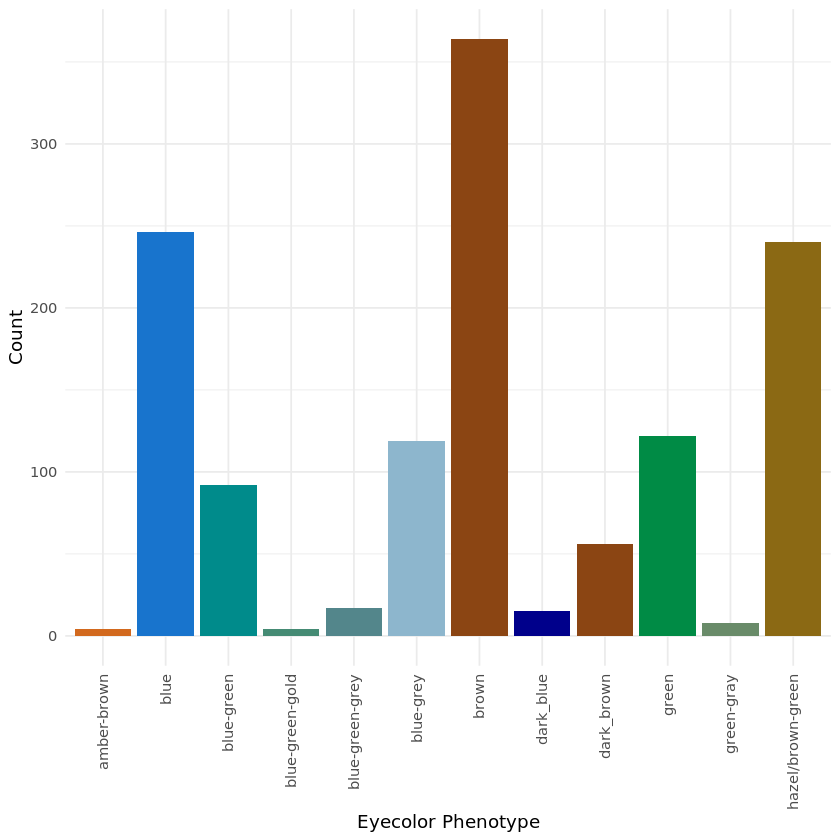

In [12]:
ggplot(phenotype) +
    geom_bar(aes(x = PHENO, fill = PHENO)) +
    theme_minimal() +
    theme(axis.text.x = element_text(angle = 90, vjust = 0.5, hjust=1),
          legend.position = "none") +
    xlab("Eyecolor Phenotype") + ylab("Count") +
    scale_fill_manual(values=c("chocolate", "dodgerblue3", "cyan4", "aquamarine4", "cadetblue4", "lightskyblue3", "saddlebrown", "darkblue", "chocolate4", "springgreen4", "darkseagreen4", "goldenrod4"))

In [4]:
phenotype$PHENO <- ifelse(grepl("brown", phenotype$PHENO), 1 , 2) #1 is all phenotypes containing the word brown, 2 is the leftover phenotypes (green, blue, gray)
phenotype$FID <- phenotype$IID
phenotype <- phenotype %>% select(FID, IID, PHENO)
phenotype %>% head()

,FID,IID,PHENO
,<int>,<int>,<dbl>
1,1010,1010,1
2,1013,1013,1
3,1020,1020,2
4,1022,1022,2
5,1024,1024,2
6,1026,1026,1


In [23]:
phenotype %>% write.table(file = "binary_phenotypes.txt", sep = "\t", row.names = FALSE, col.names = FALSE)

In [5]:
eyecolor_qc$PHENO <- phenotype$PHENO[match(eyecolor_qc$FID, phenotype$FID)]
dim(eyecolor_qc)
head(eyecolor_qc)
eyecolor_qc %>% group_by(PHENO) %>% summarise(count = n())

[1] 1260    6

,FID,IID,PAT,MAT,SEX,PHENO
,<int>,<int>,<int>,<int>,<int>,<dbl>
1,1010,1010,0,0,0,1
2,1013,1013,0,0,0,1
3,1020,1020,0,0,0,2
4,1022,1022,0,0,0,2
5,1024,1024,0,0,0,2
6,1026,1026,0,0,0,1


,PHENO,count
,<dbl>,<int>
1,1,646
2,2,614


## 3. PCA

Bash commands:
`plink --bfile eye_color_QC --indep-pairwise 500kb 5 0.2 --out eyecolor_QC_prunned`  

To use the pruned set of SNPs to calculate the relationship matrix and calculate the first 20 principle components (PCs):

`plink --bfile eye_color_QC --extract eyecolor_QC_prunned.prune.in --pca 20 --out eyecolor_QC_prunned`

In [9]:
pca <- read.table("eyecolor_QC_prunned.eigenvec")
colnames(pca) <- c(c("FID","IID"),paste(rep("PC",20),seq(1,20),sep=""))
pca <- inner_join(eyecolor_qc, pca)
head(pca)

Joining, by = c("FID", "IID")



,FID,IID,PAT,MAT,SEX,PHENO,PC1,PC2,PC3,PC4,⋯,PC11,PC12,PC13,PC14,PC15,PC16,PC17,PC18,PC19,PC20
,<int>,<int>,<int>,<int>,<int>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,1010,1010,0,0,0,1,0.00202074,-0.00609272,0.01905430,0.01674340,⋯,-0.00998954,0.006396150,-4.71689e-05,-0.01846590,-0.009941220,0.00216033,0.00331567,-0.005819210,0.00518274,-0.009117570
2,1013,1013,0,0,0,1,0.01199610,-0.00202943,-0.01134860,-0.01197120,⋯,-0.00207026,0.005528330,-2.06839e-03,-0.01046230,0.002515670,0.00571668,-0.01010910,0.000846210,-0.00156384,0.005391600
3,1020,1020,0,0,0,2,0.01031060,-0.00439452,-0.01083940,-0.01600570,⋯,-0.00389915,-0.003586840,-3.96291e-03,0.00352981,-0.005261510,-0.00106100,0.00391311,0.000061349,0.00251149,0.011249700
4,1022,1022,0,0,0,2,0.01137730,-0.00244334,-0.01104040,-0.01153080,⋯,-0.01274850,-0.002961690,-1.56590e-03,0.00563696,0.000390342,-0.00251845,-0.00438271,-0.001152080,0.00248664,0.000129061
5,1024,1024,0,0,0,2,0.00723257,-0.00212317,-0.00533853,-0.00472996,⋯,0.00596584,0.002772370,-2.61041e-03,0.00999826,-0.004277030,0.00590136,0.00146497,-0.006829140,0.00193840,-0.004048210
6,1026,1026,0,0,0,1,0.01051540,-0.00257054,-0.01416480,-0.01147720,⋯,-0.00145945,0.000652542,-3.36799e-03,0.00451055,0.004166240,0.00556789,0.00656450,0.004536430,0.00591224,0.008058460


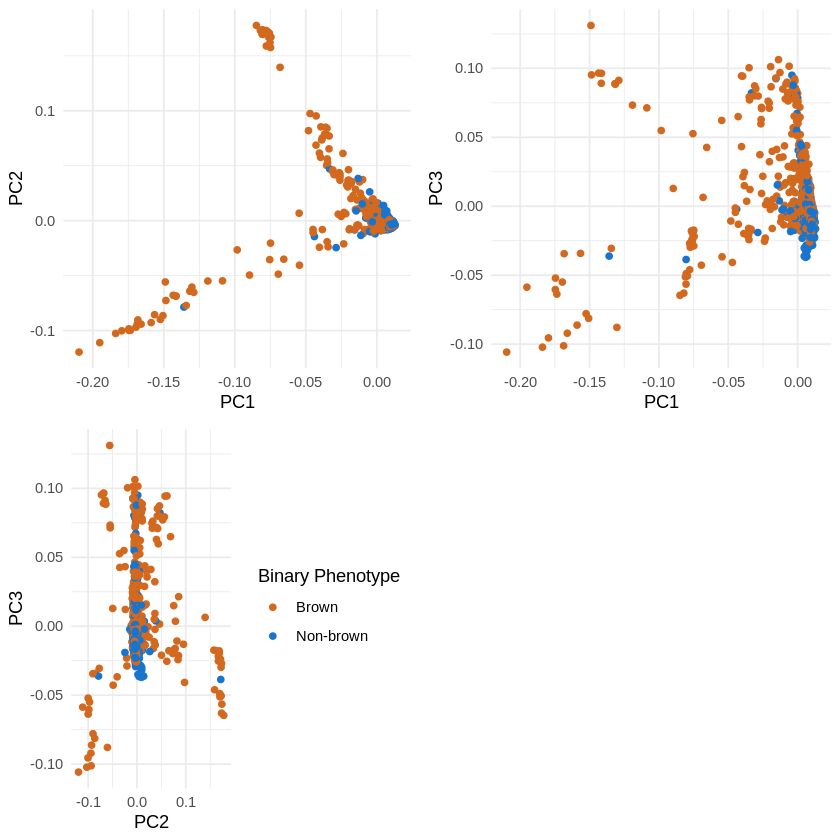

In [35]:
pca1 <- pca %>% ggplot() +
    geom_point(aes( x= PC1, y = PC2, color = PHENO)) +
    theme_minimal() +
    theme(legend.position = "none") + 
    scale_color_manual(values=c("chocolate", "dodgerblue3"))

pca2 <- pca %>% ggplot() +
    geom_point(aes( x= PC1, y = PC3, color = PHENO)) +
    theme_minimal() +
    theme(legend.position = "none") + 
    scale_color_manual(values=c("chocolate", "dodgerblue3"))

pca3 <- pca %>% ggplot() +
    geom_point(aes( x= PC2, y = PC3, color = PHENO)) +
    theme_minimal() +
    #theme(legend.position = "none") + 
    scale_color_manual(values=c("chocolate", "dodgerblue3"), 
                       labels = c("Brown", "Non-brown")) +
    guides(col=guide_legend("Binary Phenotype"))

grid.arrange(pca1, pca2, pca3, nrow = 2)

In [41]:
eigen_val <- as.data.frame(read.table("eyecolor_QC_prunned.eigenval"))
eigen_val <- eigen_val %>%
                mutate(per_var_expl=(V1/sum(eigen_val$V1))*100) %>% 
                mutate(PC = seq(1,20)) %>% 
                mutate(cumsum = cumsum(per_var_expl))

cat("The first PC approx explains ",eigen_val$per_var_expl[1],"% of the variance")

The first PC approx explains  35.69673 % of the variance

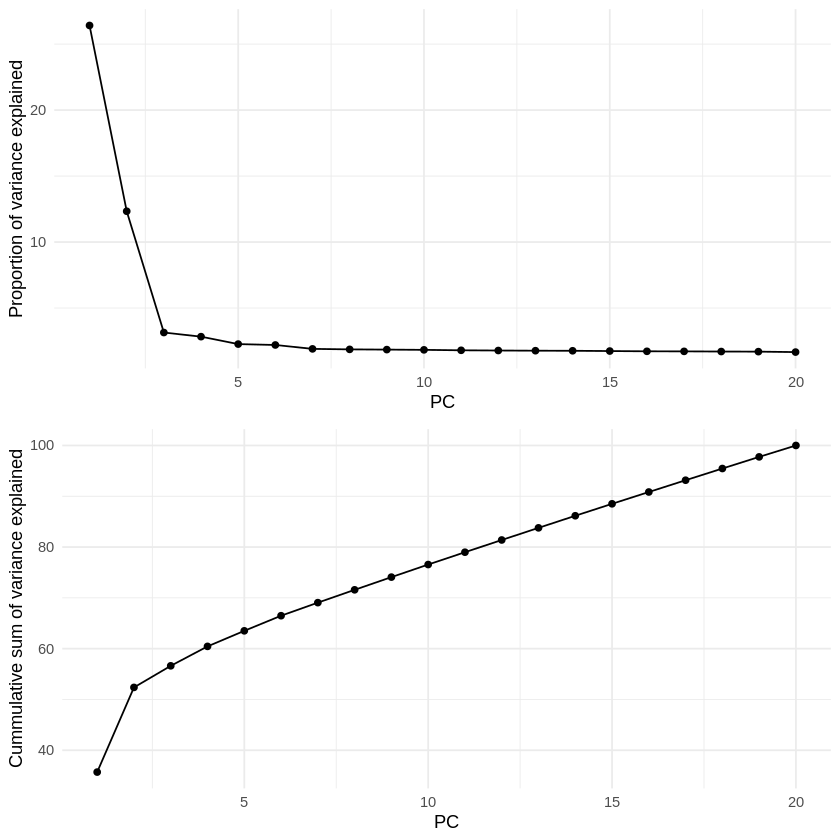

In [45]:
eigenval_plot1 <- eigen_val %>% ggplot() +
                    geom_line(aes(x = PC, y = V1)) + 
                    geom_point(aes(x=PC,y=V1))+ 
                    theme_minimal() +
                    ylab("Proportion of variance explained")

eigenval_plot2 <- eigen_val %>% ggplot() +
                    geom_line(aes(x = PC, y = cumsum)) + 
                    geom_point(aes(x=PC, y = cumsum)) + 
                    theme_minimal() +
                    ylab("Cummulative sum of variance explained")

grid.arrange(eigenval_plot1,eigenval_plot2, nrow=2)

## 4. Association test - Fisher's Exact test

Bash commands:  
`plink --bfile eye_color_QC --assoc fisher --allow-no-sex --pheno binary_phenotypes.txt --out eyecolor` 

In [1]:
assoc_fisher <- read.table("eyecolor.assoc.fisher", header = T)
head(assoc_fisher)
dim(assoc_fisher)

,CHR,SNP,BP,A1,F_A,F_U,A2,P,OR
,<int>,<chr>,<int>,<chr>,<dbl>,<dbl>,<chr>,<dbl>,<dbl>
1,1,rs3094315,752566,G,0.17930,0.20180,A,0.362100,0.8647
2,1,rs3131972,752721,A,0.18910,0.21070,G,0.188200,0.8732
3,1,rs12124819,776546,G,0.23330,0.20550,A,0.141200,1.1760
4,1,rs11240777,798959,A,0.21490,0.25520,G,0.019620,0.7988
5,1,rs6681049,800007,T,0.00885,0.02819,C,0.008567,0.3078
6,1,rs4970383,838555,A,0.26270,0.26370,C,0.962600,0.9945


[1] 838153      9

The assoc.fisher file that contains the following information:

CHR: Chromosome

SNP: SNP ID

BP: Physical position (base-pair)

A1: Minor allele name (based on whole sample)

F_A: Frequency of this allele in cases

F_U: Frequency of this allele in controls

A2: Major allele name

P: Exact p-value for this test

OR: Estimated odds ratio (for A1)

In [49]:
#Calculating Bonferroni adjusted p-values and ordering based on most significant SNPs

p <- assoc_fisher[order(assoc_fisher$P),]

p$bonf <- p.adjust(p$P, method = "bonferroni", n = nrow(p))
#assoc_fisher$bonf <- p.adjust(assoc_fisher$P, method = "bonferroni", n = nrow(assoc_fisher))

p %>% head(n = 10)

,CHR,SNP,BP,A1,F_A,F_U,A2,P,OR,bonf
,<int>,<chr>,<int>,<chr>,<dbl>,<dbl>,<chr>,<dbl>,<dbl>,<dbl>
677127,15,rs1667394,28530182,C,0.04570,0.3961,T,4.168e-100,0.07302,3.493422e-94
677124,15,rs916977,28513364,T,0.04520,0.3836,C,1.434e-92,0.07608,1.201911e-86
677125,15,rs8039195,28516084,C,0.04461,0.3511,T,2.175e-72,0.08630,1.822983e-66
677110,15,rs4778241,28338713,A,0.07980,0.3529,C,1.582e-65,0.15900,1.325958e-59
677120,15,rs11636232,28386626,T,0.48990,0.1928,C,6.431e-56,4.02200,5.390162e-50
677118,15,rs3935591,28374012,T,0.04062,0.3769,C,4.673e-55,0.06999,3.916689e-49
677109,15,rs4778138,28335820,G,0.06426,0.2852,A,1.055e-41,0.17210,8.842514e-36
677111,15,rs7495174,28344238,G,0.02362,0.1703,A,1.052e-38,0.11790,8.817370e-33
677126,15,rs16950987,28526228,A,0.01245,0.1673,G,2.238e-38,0.06273,1.875786e-32


## 5. Manhattan and QQ plots

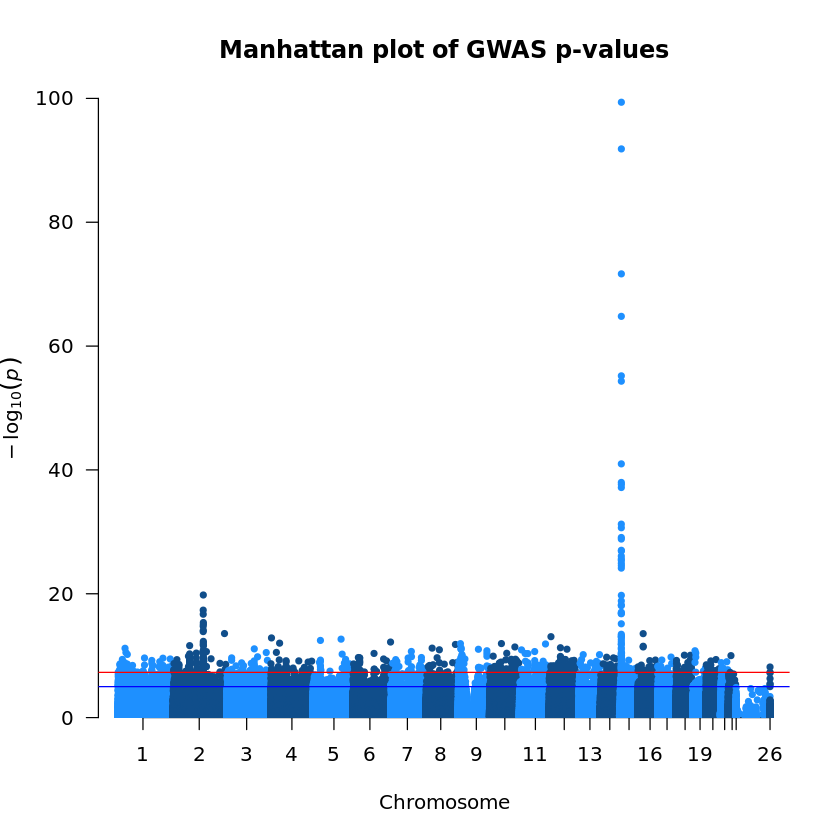

In [51]:
manhattan(assoc_fisher, col = c("dodgerblue", "dodgerblue4"), main = "Manhattan plot of GWAS p-values")

In [ ]:
#Plot shows p-values without adjustment. The red line shows the Bonferroni threshold.

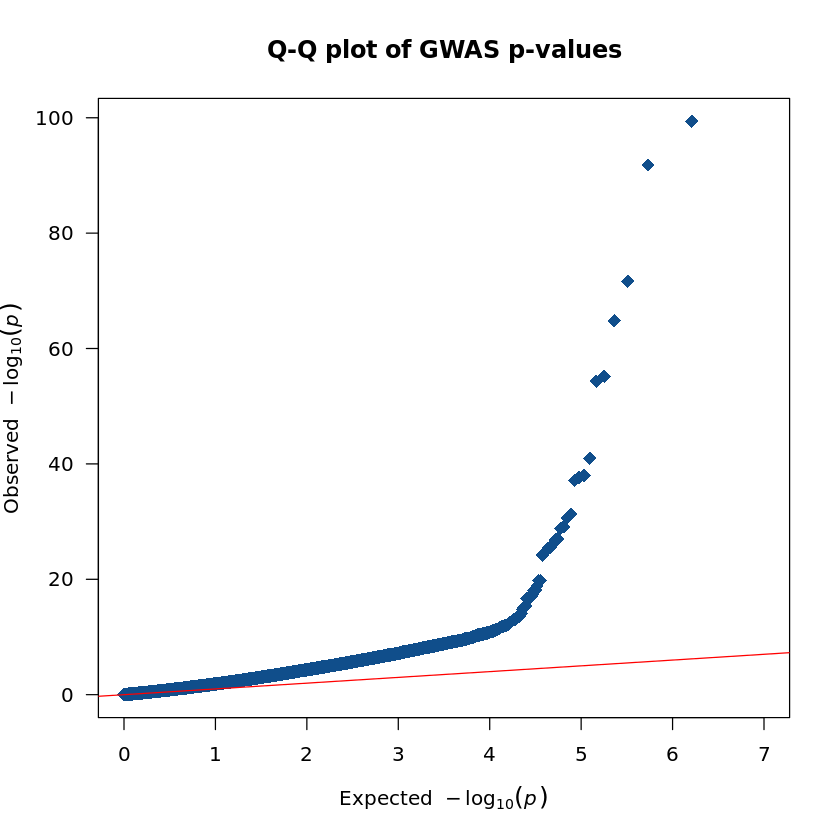

In [54]:
qq(assoc_fisher$P, main = "Q-Q plot of GWAS p-values", xlim = c(0, 7), pch = 18, col = "dodgerblue4", cex = 1.5, las = 1)

In [ ]:
#QQ plot shows inflation of the p-values

### Genomic Control.T

The inflation factor (𝝺) can be calculated as the median of the Chi-squared statistics computed divided by the median of the Chi-squared distribution under the null. Given a p-value (p) the corresponding Chi-squared quantile can be calculated as:

qchisq(p, df=1, lower.tail = F)

To do genomic control (to adjust for inflated test statistic) you divide the Chi-squared values by the inflation factor. To turn a Chi-squared quantile (q) into a p-value you use the “pchisq” function:

pchisq(q, df=1, lower.tail = F)

In [13]:
set.seed(0)
exp_med <- median(rchisq(10000000,1))
exp_med

[1] 0.4550127

In [8]:
assoc_fisher <- assoc_fisher %>% mutate(obs_qchisq = qchisq(P, df=1, lower.tail = F))

In [14]:
lambda <- median(assoc_fisher$obs_qchisq)/exp_med
cat("\nThe inflation factor is ",lambda)


The inflation factor is  1.967189

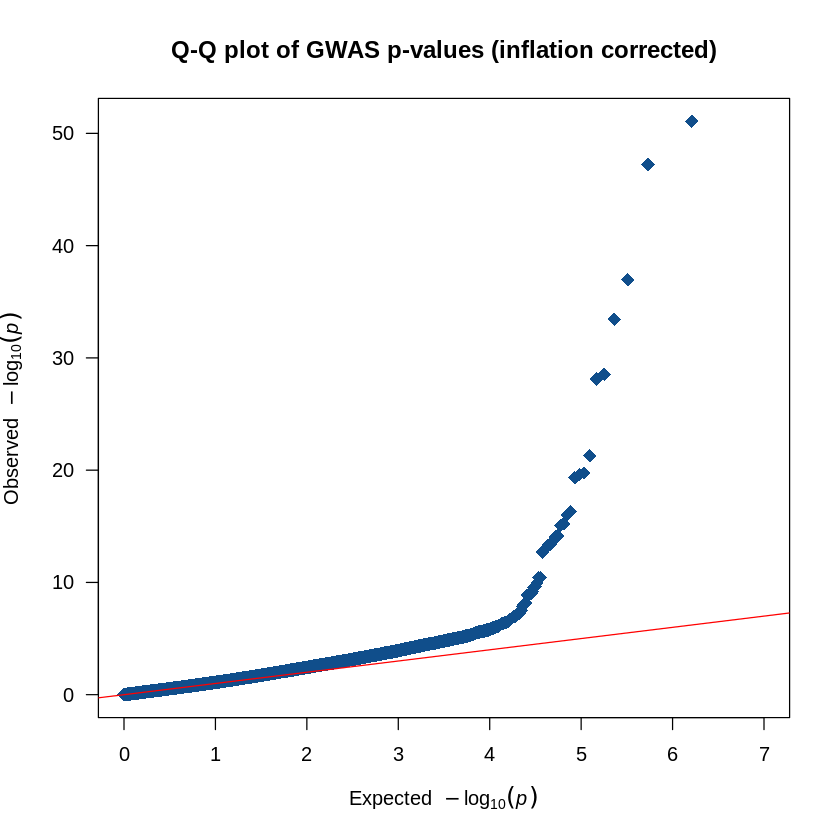

In [16]:
assoc_fisher <- assoc_fisher %>% 
  mutate(corrected_qchisq = obs_qchisq/lambda) %>%
  mutate(corrected_p = pchisq(corrected_qchisq, df=1, lower.tail = F))
qq(assoc_fisher$corrected_p, main = "Q-Q plot of GWAS p-values (inflation corrected)", 
   xlim = c(0, 7), pch = 18, col = "dodgerblue4", cex = 1.5, las = 1)

In [ ]:
#Using genomic control to correct for inflation did help a bit

In [ ]:
#DO PCA CORRECTION TO CONTROL FOR ADDITIONAL INFLATION; POPULATION STRUCTURE